In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report
from sklearn import metrics 

In [2]:
df = pd.read_csv("../songs_default.csv")
df.drop_duplicates(subset=['name', 'artist', 'mood'], keep='last',inplace=True)
df['mood'] = df['mood'].replace(['calm', 'happy','angry','depress'], [1,1,0,0])

c:\Users\rgoh1\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\Users\rgoh1\Anaconda3\lib\site-packages\seaborn\axisgrid.py:643: UserWarning: Using the violinplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


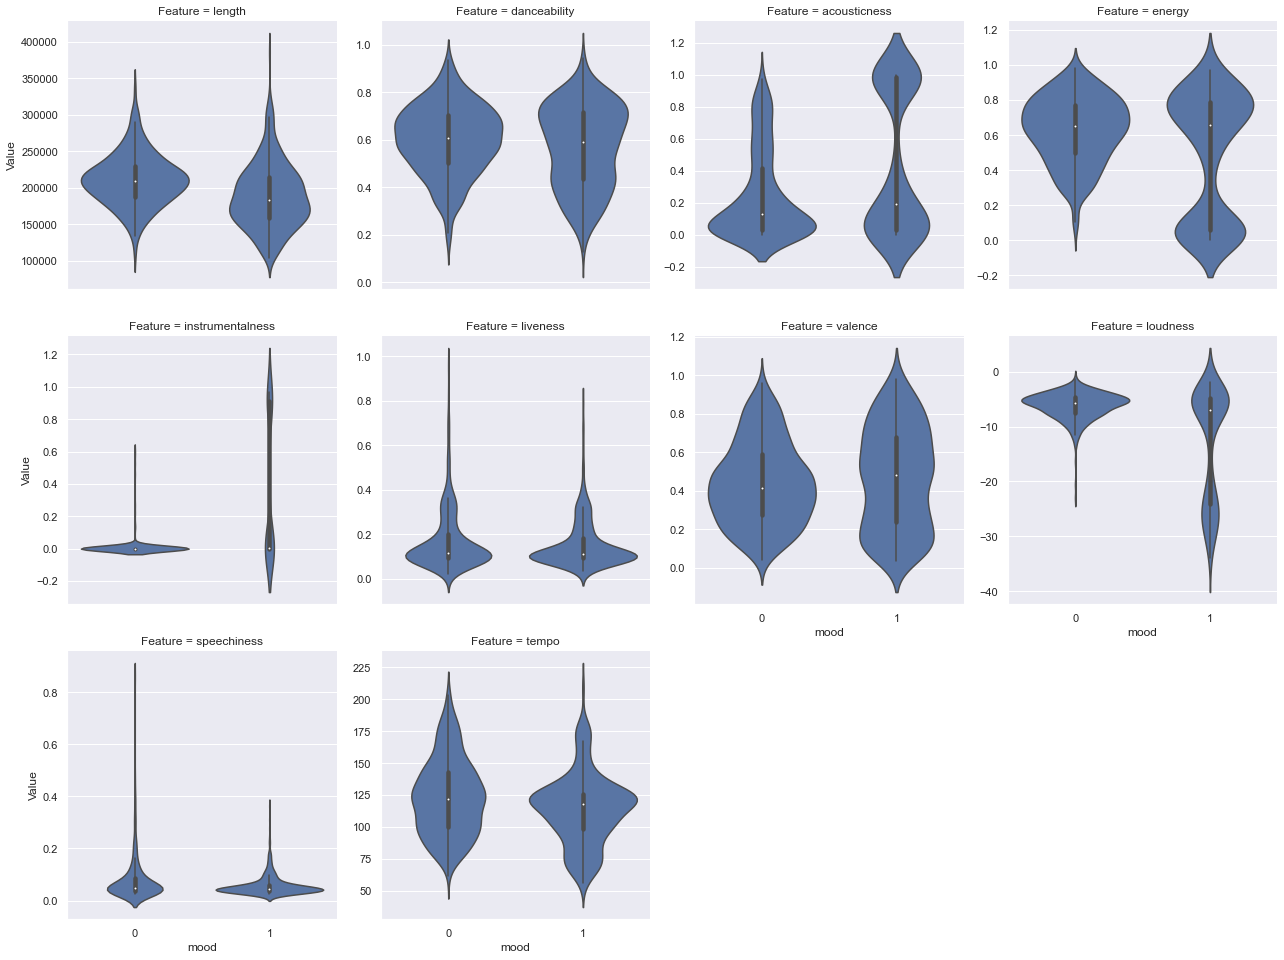

In [95]:
# Plotting distributions across moods
col_features = df.columns[7:-3]
sns.set()
df_visual = pd.DataFrame(df, columns=col_features)
df_visual['mood'] = df['mood']
df_tmp = pd.melt(df_visual, id_vars='mood', value_vars=list(df_visual.columns)[:-1],
var_name="Feature", value_name="Value")
df_tmp
g = sns.FacetGrid(data=df_tmp, col="Feature", col_wrap=4, 
size=4.5, sharey=False)
g.map(sns.violinplot, "mood", "Value")


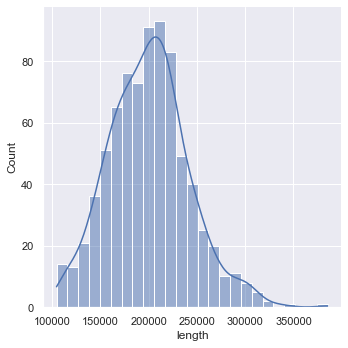

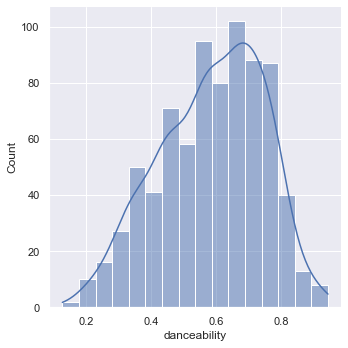

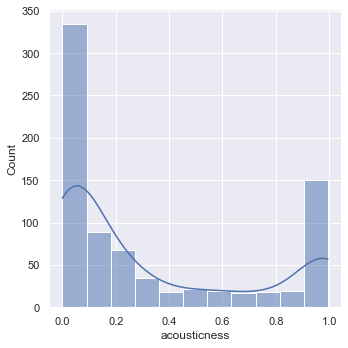

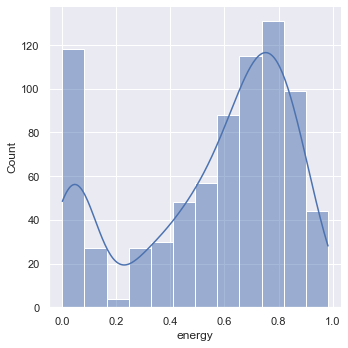

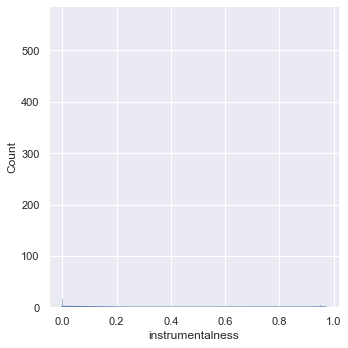

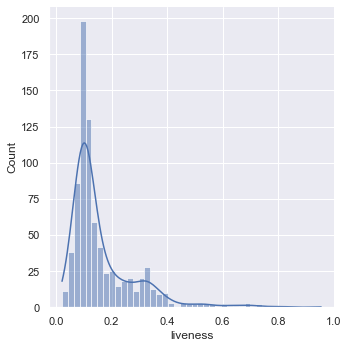

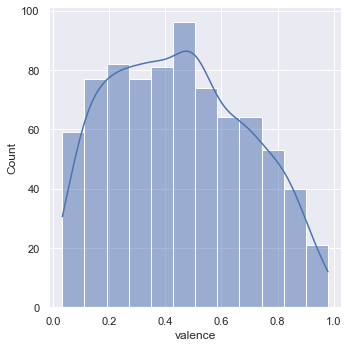

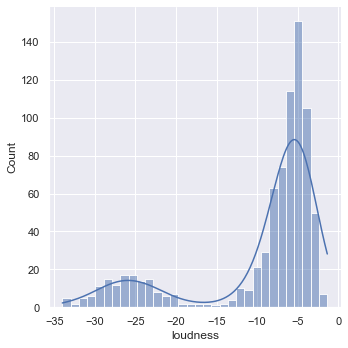

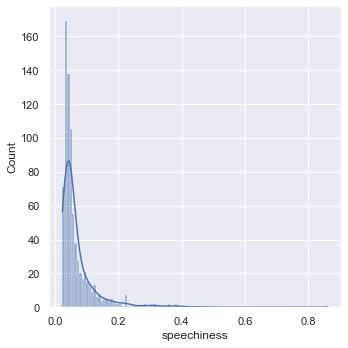

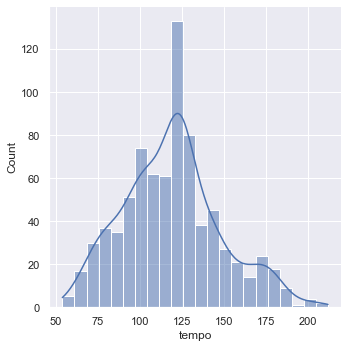

In [66]:
# Plotting distributions of each column feature, not separated by mood
col_features = df.columns[7:-3]
sns.set()
df_visual = pd.DataFrame(df, columns=col_features)
for col in col_features:
    sns.displot(df_visual[col], kde=True)


From the visualizations above, we see that many of the variables are not normally distributed in acousticness, speechiness, liveness and loudness, which will affect the assumptions of some feature selection techniques

In [3]:
col_features = df.columns[7:-3]
scaler = MinMaxScaler()
df1 = scaler.fit_transform(df[col_features])
X = pd.DataFrame(df1, columns=col_features)
Y = df[['mood']]

def create_train_test(X, Y,):
    X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)
    return X_train, Y_train

In [4]:
# Running feature selection statistical techniques (Chi2, F-Score, Mutual Info) and wrapper techniques (RFE)
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif, RFE
chi2_values = [0 for col in col_features]
f_values = [0 for col in col_features]
mut_values = [0 for col in col_features]

# run the feature selections 100 times and get the average p-values to determine which features to choose
i = 1
while i < 100:

    # Using chi-square feature selection method
    X_train, Y_train = create_train_test(X, Y)

    chi2_score, chi2_pvalue = chi2(X_train, Y_train.values.ravel())
    chi2_values = [x + y for x, y in zip(chi2_values, chi2_pvalue)]

    # Using the anova f-test univariate feature selection method
    f_score, f_pvalue = f_classif(X_train, Y_train.values.ravel())
    f_values = [x + y for x, y in zip(f_values, f_pvalue)]

    # Using the mutual info classifier univariate feature selection method
    mut_score = mutual_info_classif(X_train, Y_train.values.ravel())
    mut_values = [x + y for x, y in zip(mut_values, mut_score)]


    i += 1

chi2_values[:] = [x / 100 for x in chi2_values] 
chi2_dict = dict(zip(col_features, chi2_values))

f_values[:] = [x / 100 for x in f_values] 
f_dict = dict(zip(col_features, f_values))

mut_values[:] = [x / 100 for x in mut_values] 
mut_dict = dict(zip(col_features, mut_values))

In [5]:
# For chi2 and and f-score, we select features with a p-value less than 0.05
print([k for k,v in chi2_dict.items() if v < 0.05])
print([k for k,v in f_dict.items() if v < 0.05])

# For mut_dict, we select the top half of features
avg = sum(mut_dict.values()) / len(mut_dict)
print([k for k,v in mut_dict.items() if v > avg])

['acousticness', 'energy', 'instrumentalness', 'loudness']
['length', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo']
['acousticness', 'energy', 'instrumentalness', 'loudness']


In [6]:
# For RFE, we run using LinearSVC as the model to select top half of features
from sklearn.svm import LinearSVC
X_train, Y_train = create_train_test(X, Y)
rfe = RFE(estimator=LinearSVC(), n_features_to_select=5)
rfe = rfe.fit(X_train, Y_train)
rfe_selected = X_train.loc[:, rfe.support_]
rfe_selected.columns

c:\Users\rgoh1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rgoh1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rgoh1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\rgoh1\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

Index(['energy', 'instrumentalness', 'valence', 'loudness', 'speechiness'], dtype='object')

In [13]:
featuresets = {
 "f-score" : ['length', 'danceability', 'acousticness', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo'],
"chi2" : ['acousticness', 'energy', 'instrumentalness', 'loudness'],
"mut" : ['acousticness', 'energy', 'instrumentalness', 'loudness'],
"rfe" : ['energy', 'instrumentalness', 'valence', 'loudness', 'speechiness']
}

In [8]:
score_list = []
def runway_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train.values.ravel())
        
    y_pred = model.predict(X_test) # make prediction
    
    # test recall and f1-score
    test_acc = metrics.accuracy_score(y_test, y_pred) 
    test_prec = metrics.precision_score(y_test, y_pred, average="macro")
    test_recall = metrics.recall_score(y_test, y_pred, average="macro") 
    test_f1 = metrics.f1_score(y_test, y_pred, average="macro")
    scores = {'test' : [round(test_acc, 5), round(test_prec, 5), 
                        round(test_recall, 5), round(test_f1, 5)]}
    return scores

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC


models = {
    'LinearSVC': LinearSVC(max_iter=10000),
    'Logistic Regression': LogisticRegression(max_iter= 10000, random_state= 15),
    'Decision Tree': DecisionTreeClassifier(random_state=15),
    'Random Forest': RandomForestClassifier(random_state= 15),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Neural Network': MLPClassifier(max_iter= 10000, random_state= 15),
    'Gradient Boosting': GradientBoostingClassifier(random_state= 15),
    'LightGBM': LGBMClassifier(random_state= 15),
    'CatBoost': CatBoostClassifier(verbose= 0),
    'GNB': GaussianNB(),
    'Random Forest': RandomForestClassifier(random_state=15),
    'Adaboost': AdaBoostClassifier(random_state=15),
    'Adaboost_LR': AdaBoostClassifier(base_estimator=LogisticRegression(max_iter=10000, random_state= 15)
                                                ,random_state=15),
}    

In [14]:
headers = ['model-type', 'accuracy-score', 'precision-score', 'recall-score', 'f1-score']
pd.set_option('max_row', None)
for featureset in featuresets:
    output_df = pd.DataFrame(columns = headers)
    for name, model in models.items():
        X_new = X[featuresets[featureset]]
        X_train, X_test, Y_train, Y_test = train_test_split(X_new, Y, test_size=0.2, random_state=15)
        scores = runway_model(model, X_train, X_test, Y_train, Y_test)['test']
        scores.insert(0, name)
        output_df = output_df.append(pd.DataFrame([scores], columns = headers), ignore_index = True)
    print("Featureset results for " + featureset)
    print(output_df)

Featureset results for f-score
             model-type  accuracy-score  precision-score  recall-score  \
0             LinearSVC         0.75316          0.74996       0.75065   
1   Logistic Regression         0.74684          0.75158       0.73328   
2         Decision Tree         0.70253          0.69880       0.69935   
3         Random Forest         0.74684          0.74370       0.74497   
4   K-Nearest Neighbors         0.74051          0.73823       0.74075   
5        Neural Network         0.75949          0.76026       0.76364   
6     Gradient Boosting         0.78481          0.78424       0.77760   
7              LightGBM         0.76582          0.76301       0.76494   
8              CatBoost         0.78481          0.78235       0.78052   
9                   GNB         0.67089          0.74126       0.63442   
10             Adaboost         0.76582          0.76516       0.75763   
11          Adaboost_LR         0.68354          0.77923       0.64578   

    f1